In [1]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import acquire
import helpers.nlp
import helpers.viz


In [2]:
df = acquire.wrangle_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1031 non-null   object
 1   language         917 non-null    object
 2   readme_contents  1027 non-null   object
dtypes: object(3)
memory usage: 24.3+ KB


# Prepping the data

### Language Nulls
Many repositories do not have a language associated with them.  I suspect that this is due to repositories that are intended to share conceptual information rather than any actual code.

In [4]:
df[df.language.isna()].sample(10, random_state=8)

,repo,language,readme_contents
221,nodejs/node-v0.x-archive,NaN,\nThis repository is an archive of Node.js bef...
939,markerikson/react-redux-links,NaN,# React/Redux Links\nCurated tutorial and reso...
511,mbeaudru/modern-js-cheatsheet,NaN,# Modern JavaScript Cheatsheet\n\n![Modern Jav...
472,johnpapa/angular-styleguide,NaN,# Angular Style Guide\n\n## Versions\nThere ar...
186,Developer-Y/cs-video-courses,NaN,# Computer Science courses with video lectures...
2,EbookFoundation/free-programming-books,NaN,# List of Free Learning Resources In Many Lang...
733,google/eng-practices,NaN,# Google Engineering Practices Documentation\n...
610,datawhalechina/pumpkin-book,NaN,"<div align=center>\n<img src=""https://raw.gith..."
872,akullpp/awesome-java,NaN,# Awesome Java [![Awesome](https://awesome.re/...
124,enaqx/awesome-react,NaN,### **Awesome React** [![Awesome](https://cdn....


After manually inspecting some of these repos I feel confident in my assumption.  Many of these repositories are a compilation of tutorials, or a list of resources.  In fact, we should keep the following phrases/keywords in mind for identifying these types of repositories:  
- `curated [list/tutorial/resource]`
- `courses`
- `learning resource`
- `cheatsheet`

In [5]:
# Committing to the asumption and imputing as english
df.language = df.language.fillna('English')

### Readme Nulls

In [6]:
df.readme_contents.isna().sum()

4

There's only 4 of them.  I don't want to waste time investigating.  We'll just drop them.

In [7]:
df = df.dropna()

In [8]:
df.language.value_counts()

JavaScript          232
Python              114
English             114
TypeScript          109
Go                   76
Java                 70
C++                  55
C                    30
HTML                 23
Shell                22
Rust                 21
Swift                18
Ruby                 18
Jupyter Notebook     14
PHP                  14
C#                   13
Kotlin               12
CSS                  12
Vue                   8
Objective-C           5
Lua                   4
Dart                  4
Vim script            3
Haskell               3
Markdown              3
SCSS                  3
TeX                   3
Elixir                2
Vim Script            2
Clojure               2
Makefile              2
Zig                   1
Emacs Lisp            1
OCaml                 1
Julia                 1
CoffeeScript          1
Objective-C++         1
AsciiDoc              1
Nunjucks              1
Batchfile             1
Scala                 1
Jinja           

## Small class sizes
Some languages only appear a small number of times

In [9]:
lang_to_keep = df.language.value_counts()[df.language.value_counts() > 10].index
df = df[df.language.isin(lang_to_keep)]

In [10]:
df.language.value_counts()

JavaScript          232
Python              114
English             114
TypeScript          109
Go                   76
Java                 70
C++                  55
C                    30
HTML                 23
Shell                22
Rust                 21
Ruby                 18
Swift                18
PHP                  14
Jupyter Notebook     14
C#                   13
CSS                  12
Kotlin               12
Name: language, dtype: int64

### Content cleaning
As a starting point we'll normalize the text

In [11]:
df['cleaned'] = df.readme_contents.apply(helpers.nlp.sanitize)

In [12]:
def get_word_freq(document, max=None, min=None):
    if type(document) != str:
        document = ' '.join(document)
    bag =  document.split(' ')
    series = pd.Series(bag)
    vc = series.value_counts()
    if max:
        vc = vc[vc <= max]
    if min:
        vc = vc[vc >= min]
    return vc


In [13]:
get_word_freq(df.cleaned)

'                                                                                   33537
&#9;                                                                                10110
use                                                                                  6068
react                                                                                5907
data                                                                                 5725
                                                                                    ...  
sslmzstaticcomimagethumbpurple62v468a29e68a29ead                                        1
7597                                                                                    1
31c8                                                                                    1
5a31                                                                                    1
openhttpsnetronappurlhttpsrawgithubusercontentcomalexeyabdarknetmastercfgyolocfg        1
Length: 24

The string `&#9;` is very popular. Probably because seems to point to html codes for square brackets "[]" which is very common in markup files.. which the readme files are.  We'll add this one to the stopwords list.  

We'll go ahead and add apostrophes to the stopword list as well

Also there seems to be a large amount of urls being captured as single words.  We'll want to scrub those as well to reduce noise.

In [14]:
links = re.compile(r'(\(http.+\))')
html = re.compile(r'(<.*?>)')
cplusplus = re.compile(r'([cC]\+\+\W)')
csharp = re.compile(r'([cC]\#\W)')
df.readme_contents = df.readme_contents.replace(html, '')
df.readme_contents = df.readme_contents.replace(links, '')
df.readme_contents = df.readme_contents.replace(cplusplus, 'cplusplus')
df.readme_contents = df.readme_contents.replace(csharp, 'csharp')

In [15]:
df[df.readme_contents.str.contains('cplusplus')].head()

,repo,language,readme_contents,cleaned
3,jwasham/coding-interview-university,English,# Coding Interview University\n\n> I originall...,coding interview university originally created...
8,tensorflow/tensorflow,C++,\n \n\n\n[![Python]\n[![PyPI]\n[![DOI]\n[![CI...,div aligncenter img srchttpswwwtensorfloworgim...
16,vinta/awesome-python,Python,# Awesome Python [![Awesome]\n\nA curated list...,awesome python awesomehttpscdnrawgitcomsindres...
22,jackfrued/Python-100-Days,Python,## Python - 100天从新手到大师\n\n> **作者**：骆昊\n>\n> **...,python 100 8w15python core 50 courseshttpsgith...
23,ossu/computer-science,English,![Open Source Society University (OSSU)]\n\nOp...,open source society university ossuhttpsiimgur...


In [16]:
df[df.readme_contents.str.contains('csharp')].head()

,repo,language,readme_contents,cleaned
16,vinta/awesome-python,Python,# Awesome Python [![Awesome]\n\nA curated list...,awesome python awesomehttpscdnrawgitcomsindres...
32,awesome-selfhosted/awesome-selfhosted,JavaScript,# Awesome-Selfhosted\n\n[![Awesome]\n\nSelf-ho...,awesome selfhosted awesomehttpscdnjsdelivrnetg...
35,justjavac/free-programming-books-zh_CN,English,免费的编程中文书籍索引\n============================\n\n[...,httpsimgshieldsiogithubissuesjustjavacfree pro...
38,avelino/awesome-go,Go,# Awesome Go\n\n\n\n[![Build Status]\n[![Aweso...,awesome go hrefhttpsawesome gocomimg alignrigh...
40,microsoft/terminal,C++,![terminal-logos]\n\n# Welcome to the Windows ...,terminal logoshttpsuser imagesgithubuserconten...


In [17]:
df['cleaned'] = df.readme_contents.apply(helpers.nlp.sanitize, extra_words=['&#9;', "'", 'nbsp'])

In [18]:
get_word_freq(df.cleaned)

1                           5882
use                         5698
react                       5257
data                        4959
using                       4285
                            ... 
datamapperdocszhcnactive       1
recorddocszhcnactive           1
mapperdocszhcnactive           1
certbotreadmerst               1
exermote                       1
Length: 126407, dtype: int64

In [19]:
df['lemma'] = df.cleaned.apply(helpers.nlp.lemmatize)

In [20]:
df.head()

,repo,language,readme_contents,cleaned,lemma
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner]\n\n[![Pull Requ...,freecodecamp social banner pull requests welco...,freecodecamp social banner pull request welcom...
1,996icu/996.ICU,English,[996.ICU]\n=======\n**Please note that there e...,996icu please note exists official account app...,996icu please note exists official account app...
2,EbookFoundation/free-programming-books,English,# List of Free Learning Resources In Many Lang...,list free learning resources many languages aw...,list free learning resource many language awes...
3,jwasham/coding-interview-university,English,# Coding Interview University\n\n> I originall...,coding interview university originally created...,coding interview university originally created...
4,kamranahmedse/developer-roadmap,TypeScript,\n \n roadmap.sh\n Community driven roadmap...,roadmapsh community driven roadmaps articles r...,roadmapsh community driven roadmaps article re...


In [21]:
df['stem'] = df.cleaned.apply(helpers.nlp.stem)

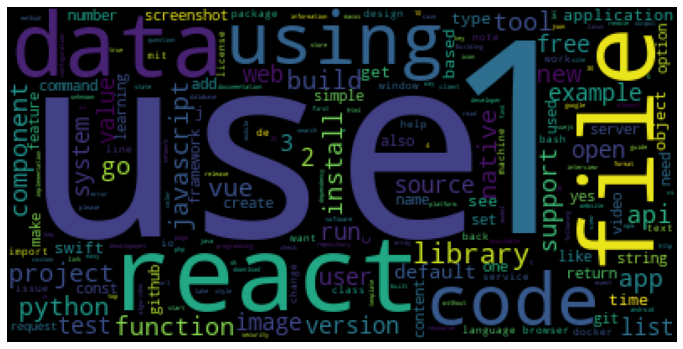

In [22]:
helpers.viz.plot_wordcloud(df.lemma)

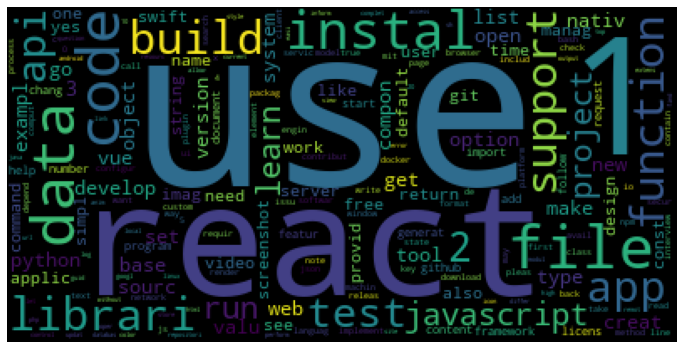

In [23]:
helpers.viz.plot_wordcloud(df.stem)

In [24]:
keep = df.language.value_counts()[df.language.value_counts() > 10].index
df = df[df.language.isin(keep)]

In [25]:
df['bigrams'] = df.lemma.apply(helpers.nlp.make_ngrams, n=2)

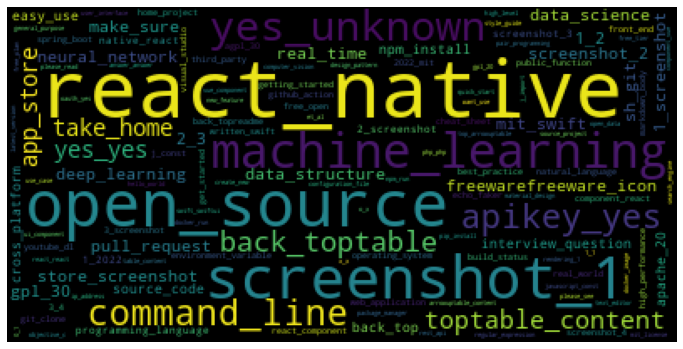

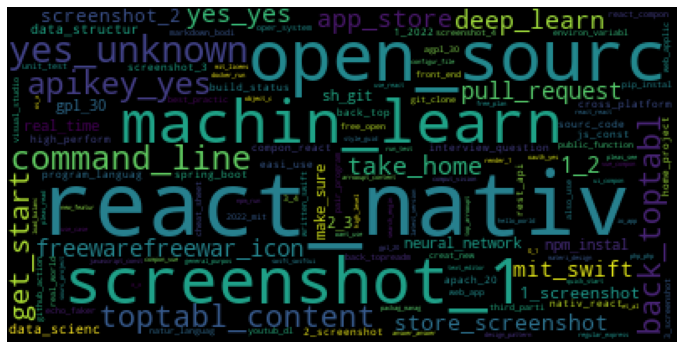

In [26]:
helpers.viz.plot_wordcloud(df.bigrams)
helpers.viz.plot_wordcloud(df.stem.apply(helpers.nlp.make_ngrams, n=2))

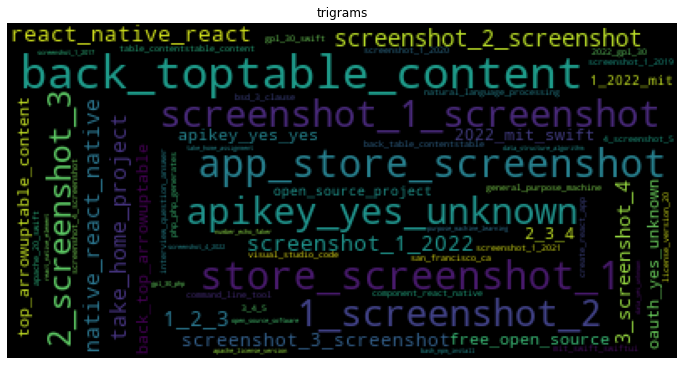

In [27]:
df['trigrams'] = df.lemma.apply(helpers.nlp.make_ngrams, n=3)
helpers.viz.plot_wordcloud(df.trigrams, title='trigrams')

In [28]:
df.language.unique().tolist()

['TypeScript',
 'English',
 'Python',
 'JavaScript',
 'C++',
 'Shell',
 'C',
 'Java',
 'Go',
 'Rust',
 'C#',
 'CSS',
 'PHP',
 'HTML',
 'Ruby',
 'Kotlin',
 'Jupyter Notebook',
 'Swift']

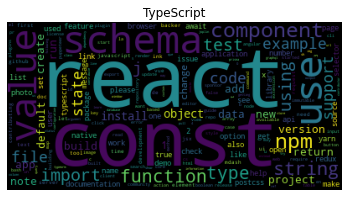

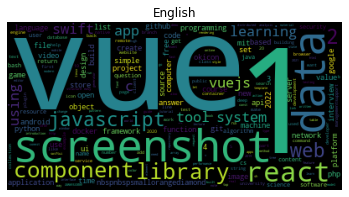

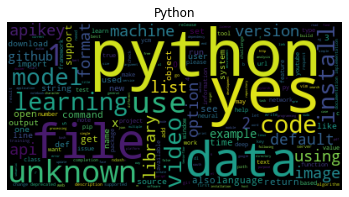

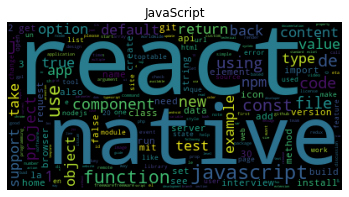

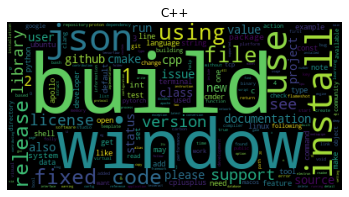

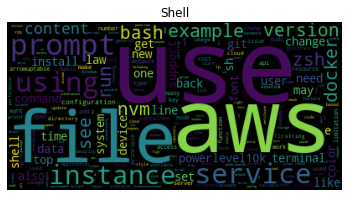

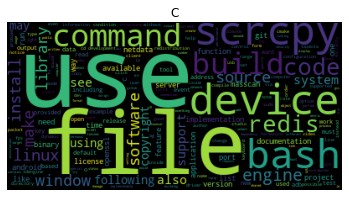

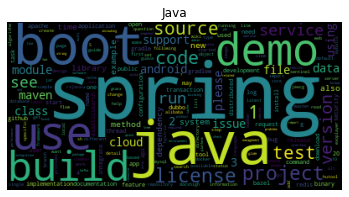

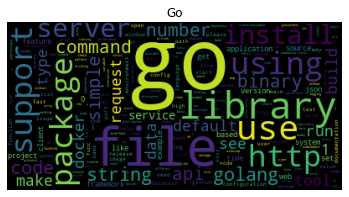

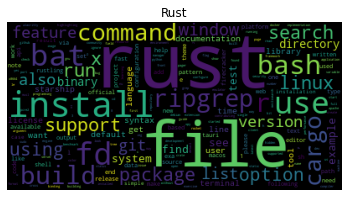

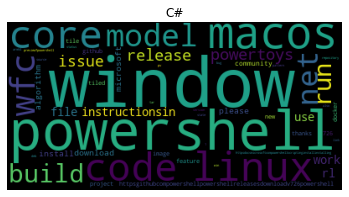

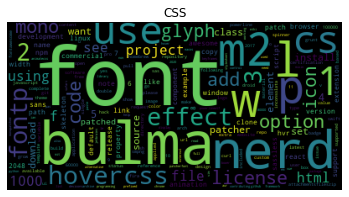

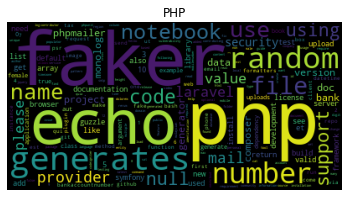

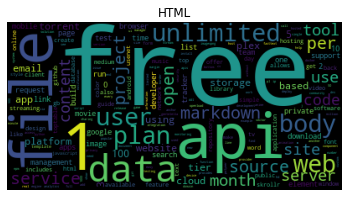

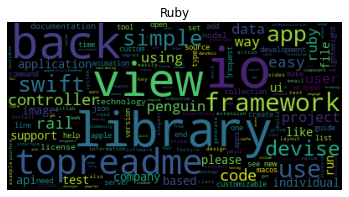

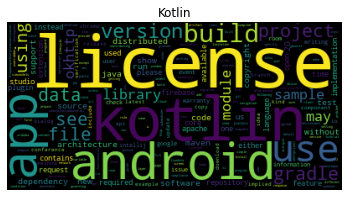

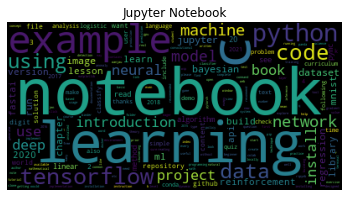

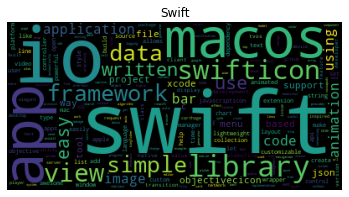

In [29]:
for cat in df.language.unique().tolist():
    helpers.viz.plot_wordcloud(df[df.language == cat].lemma, title=cat, figsize=[6,5])

# Model Prep

In [30]:
import helpers.prep

train, validate, test = helpers.prep.train_test_validate_split(df, stratify='language')

### Upsampling

In [31]:
from sklearn.utils import resample
SEED = 8
# get a list of classes that don't meet n
n = 50
target = 'language'
vc = df[target].value_counts()
to_upsample = vc[vc < n].index.tolist()
samples = pd.DataFrame()
for cat in to_upsample:
    cat_upsample = resample( df[df[target] == cat],   #DF of samples to replicate
                                replace = True,         #Implements resampling with replacement, Default=True
                                n_samples = n,          #Number of samples to produce
                                random_state= SEED         #Random State seed for reproducibility
                                )
    samples = pd.concat([samples, cat_upsample])

samples.language.value_counts()

C                   50
HTML                50
Shell               50
Rust                50
Ruby                50
Swift               50
PHP                 50
Jupyter Notebook    50
C#                  50
CSS                 50
Kotlin              50
Name: language, dtype: int64

In [32]:
df[~df[target].isin(to_upsample)].language.value_counts()

JavaScript    232
English       114
Python        114
TypeScript    109
Go             76
Java           70
C++            55
Name: language, dtype: int64

In [33]:
### Given a df, a target column, and a target number: upsample classes with a count less than target number to match target number
def upsample_to_n(df, target, n, seed=SEED):
    # get a list of classes that don't meet n
    vc = df[target].value_counts()
    to_upsample = vc[vc < n].index.tolist()
    # Build a DF of new_samples
    new_samples = pd.DataFrame()
    for cat in to_upsample:
        cat_upsample = resample( df[df[target] == cat],   #DF of new_samples to replicate
                                    replace = True,         #Implements resampling with replacement, Default=True
                                    n_samples = n,          #Number of new_samples to produce
                                    random_state= SEED         #Random State seed for reproducibility
                                    )
        new_samples = pd.concat([new_samples, cat_upsample])
    old_samples = df[~df[target].isin(to_upsample)]
    return pd.concat([old_samples, new_samples])


In [34]:
xf = df.copy()

In [35]:
df = upsample_to_n(df, 'language', 50)

In [42]:
df.language.value_counts()

JavaScript          232
Python              114
English             114
TypeScript          109
Go                   76
Java                 70
C++                  55
Swift                50
CSS                  50
C#                   50
Jupyter Notebook     50
PHP                  50
Shell                50
Ruby                 50
Rust                 50
HTML                 50
C                    50
Kotlin               50
Name: language, dtype: int64

### Modeling

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(train.lemma)
# tfidf.fit(df.lemma)

xt = tfidf.transform(train.lemma).toarray()
xs = tfidf.transform(test.lemma).toarray()
xv = tfidf.transform(validate.lemma).toarray()

In [37]:
yt = train.language
ys = test.language
yv = validate.language

In [39]:
yt.value_counts()

JavaScript          139
English              68
Python               68
TypeScript           65
Go                   46
Java                 42
C++                  33
C                    18
HTML                 14
Rust                 13
Shell                13
Swift                11
Ruby                 11
PHP                   9
Jupyter Notebook      8
C#                    8
Kotlin                7
CSS                   7
Name: language, dtype: int64

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

models = {
    "Baseline": helpers.eval.BaselineModel(method='mode'),
    "Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    # "Logistic Regression": LogisticRegression(),
    # "Gaussian Process": GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=100),
    # "XG Boost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Linear SVM": SVC(C=0.025, kernel="linear"),
    "RBF SVM": SVC(C=1, gamma=2),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    }

In [51]:
import time
out = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(xt, yt)
    stop_time = time.time()
    print(f'Fit {name} in {stop_time-start_time}')
    out[name] = {'start': start_time, 'stop': stop_time, 'dur':stop_time-start_time}

Fit Baseline in 0.0010008811950683594
Fit Nearest Neighbors in 0.08756017684936523
Fit Decision Tree in 8.24582815170288
Fit Random Forest in 4.737004518508911
Fit AdaBoost in 130.28645658493042
Fit Naive Bayes in 1.1228241920471191


c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Fit QDA in 14.512391567230225
Fit Linear SVM in 68.14488434791565
Fit RBF SVM in 73.25622820854187
Fit Neural Net in 632.220362663269


In [54]:
from sklearn.metrics import accuracy_score

model = models['Neural Net']
pt = model.predict(xt)
ps = model.predict(xs)

accuracy_score(yt, pt), accuracy_score(ys, ps)

(0.9155172413793103, 0.4845360824742268)

In [58]:
for name, model in models.items():
    start_time = time.time()
    pt = model.predict(xt)
    out[name]['train_accuracy'] = accuracy_score(yt, pt)
    stop_time = time.time()
    print(f"Predicted train with {name} in {stop_time-start_time}")
    start_time = time.time()
    ps = model.predict(xs)
    out[name]['test_accuracy'] = accuracy_score(ys, ps)
    stop_time = time.time()
    print(f"Predicted test with {name} in {stop_time-start_time}")
    

Predicted train with Baseline in 0.0009996891021728516
Predicted test with Baseline in 0.0
Predicted train with Nearest Neighbors in 1.7672057151794434
Predicted test with Nearest Neighbors in 0.5719461441040039
Predicted train with Decision Tree in 0.16499924659729004
Predicted test with Decision Tree in 0.06121516227722168
Predicted train with Random Forest in 0.22456026077270508
Predicted test with Random Forest in 0.09251976013183594
Predicted train with AdaBoost in 9.54963755607605
Predicted test with AdaBoost in 3.341066360473633
Predicted train with Naive Bayes in 13.491674900054932
Predicted test with Naive Bayes in 4.39703369140625
Predicted train with QDA in 5.960333347320557
Predicted test with QDA in 2.2185535430908203
Predicted train with Linear SVM in 26.36584234237671
Predicted test with Linear SVM in 8.760260581970215
Predicted train with RBF SVM in 57.42795372009277
Predicted test with RBF SVM in 19.241975784301758
Predicted train with Neural Net in 0.2915635108947754


In [59]:
pd.DataFrame.from_dict(out, orient='index')

,start,stop,dur,train_accuracy,test_accuracy
Baseline,1.662481e+09,1.662481e+09,0.001001,0.239655,0.242268
Nearest Neighbors,1.662481e+09,1.662481e+09,0.087560,0.508621,0.355670
Decision Tree,1.662481e+09,1.662481e+09,8.245828,0.525862,0.345361
Random Forest,1.662481e+09,1.662481e+09,4.737005,0.593103,0.329897
AdaBoost,1.662481e+09,1.662481e+09,130.286457,0.272414,0.252577
Naive Bayes,1.662481e+09,1.662481e+09,1.122824,0.996552,0.324742
QDA,1.662481e+09,1.662481e+09,14.512392,0.998276,0.072165
Linear SVM,1.662481e+09,1.662481e+09,68.144884,0.239655,0.242268
RBF SVM,1.662481e+09,1.662481e+09,73.256228,0.998276,0.226804
Neural Net,1.662481e+09,1.662482e+09,632.220363,0.915517,0.484536
